In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
pd.options.display.max_columns = None
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
#df = pd.read_csv('Datasets\deptos.csv')
df = pd.read_csv('Datasets\deptos_en_limpieza.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26299 entries, 0 to 26298
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               26299 non-null  int64  
 1   monto            26299 non-null  int64  
 2   ppm2             26294 non-null  float64
 3   superficie_t     26299 non-null  float64
 4   superficie_u     26066 non-null  float64
 5   terraza          16981 non-null  float64
 6   ambientes        9024 non-null   float64
 7   dormitorios      25597 non-null  float64
 8   banos            23986 non-null  float64
 9   estacionamiento  14750 non-null  float64
 10  bodegas          13590 non-null  float64
 11  cantidad_pisos   16239 non-null  float64
 12  dep_por_piso     13273 non-null  float64
 13  piso             16174 non-null  float64
 14  tipo_depto       20883 non-null  object 
 15  orientacion      17124 non-null  object 
 16  antiguedad       20586 non-null  float64
 17  latitud     

#### Observaciones:
- ppm2 es monto/superficie_u

In [4]:
df.sample(5)

,id,monto,ppm2,superficie_t,superficie_u,terraza,ambientes,dormitorios,banos,estacionamiento,bodegas,cantidad_pisos,dep_por_piso,piso,tipo_depto,orientacion,antiguedad,latitud,longitud,comuna,calle
10704,1591115255,4100,105.00,45.00,39.00,6.00,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.45,-70.57,Ñuñoa,Avenida Irarrázaval
21345,2855167782,10000,83.00,126.00,120.00,6.00,NaN,3.00,2.00,1.00,1.00,5.00,10.00,5.00,Departamento,NOSP,1.00,-33.45,-70.59,Ñuñoa,García Moreno
19145,2802188314,3325,51.00,68.30,64.70,3.60,NaN,3.00,2.00,NaN,NaN,18.00,NaN,2.00,Departamento,NaN,11.00,-33.51,-70.66,San Miguel,Tercera Avenida
7295,1585340457,12700,113.00,133.00,112.00,NaN,5.00,3.00,3.00,3.00,NaN,10.00,NaN,NaN,NaN,NaN,30.00,-33.42,-70.58,Las Condes,General Ludwig
2291,2857794918,2200,45.00,50.00,48.00,2.00,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.52,-70.65,San Miguel,San Petersburgo


In [ ]:
#df.to_excel('deptos.xlsx', index=False)

### Seguir revisando en ese excel exportado los años que hay que revisar. como 1025, 181, 508, 1820, 914, 1023, 1816

In [7]:
def procesar_antiguedad(valor):
    if pd.isnull(valor):
        return np.nan
    
    # Quitar texto y símbolos innecesarios
    valor = str(valor).replace('años', '').replace('-', '').replace('.', '').strip()
    
    # Si no quedan solo dígitos, algo raro pasó
    if not valor.isdigit():
        return np.nan
    
    numero = int(valor)
    
    # Si parece un año (1800–2025)
    if 1800 <= numero <= 2025:
        return 2025 - numero
    
    # Si parece una antigüedad razonable
    if 0 <= numero <= 150:
        return numero
    
    # Todo lo demás se descarta
    return np.nan

# Aplicar al DataFrame
df['antiguedad'] = df['antiguedad'].apply(procesar_antiguedad)


In [10]:
# Ajustamos el formato de algunas columnas
columnas_a_convertir = ['ambientes', 'dormitorios', 'banos', 'estacionamiento', 'bodegas', 'cantidad_pisos', 'dep_por_piso', 'piso', 'antiguedad']  # Reemplaza con tus nombres reales
df[columnas_a_convertir] = df[columnas_a_convertir].astype('Int64')  # Usa 'Int64' para permitir valores NaN


In [11]:
df['antiguedad'].unique()
#df['antiguedad'].describe()

<IntegerArray>
[  1,   2,   6,   0,  26,  21,  30,  13,  29,  16,
 ...
 105,  89, 100,  87, 122,  82, 110,  92,  96, 209]
Length: 105, dtype: Int64

In [6]:
df['monto'].unique()

array([11200, 17490, 21000, ...,  2208,  1694,  2324], dtype=int64)

#### Borramos columnas que sabemos inutiles o redundantes.
 - ubicacion: Información escrita por los usuarios que publican en el sitio, sin validación y con distintos formatos. Cualquier informacion valioza al respecto se puede obtener mediante las coordenadas.
 - direccion_num: Mismos valores que en columna calle, error de la API o el llamado a esta. 
 - region: Todos los valores son Región Metropolitana de Santiago.
 - pais: Todos los valores son Chile.
 - fecha_consultado: No tiene mayor relevancia, todos fueron consultados en un rango 1 mes y 8 dias.
 - fecha_publicado: 6000 datos faltantes aprox. El proyecto no contempla el factor temporal por ahora.
 - gastos_comunes: solo hay 2 datos no nulos. Problema en el scraping. Intentaré obtener esos datos si es posible pero por ahora proseguiré sin ellos.
 - link: información redundante con id
 - nombre: Información escrita por los usuarios que publican en el sitio, sin validación y con distintos formatos. Incluyen comentarios apreciativos y subjetivos.
 - ppm2_avg: Precio promedio en la zona. No se conoce los criterios para este cálculo, como el metodo para determinar la zona, las similitudes necesarias para comparar con otras viviendas, etc.
 - divisa: tanto monto como ppm2 está todo expresado en UF

##### Las demás columnas requieren más análisis

In [ ]:
# Borramos las columnas mencionadas
#df.drop(columns=["ubicacion", "direccion_num", "region", "pais", "fecha_consultado", "fecha_publicado", "gastos_comunes", "link", "nombre", "ppm2_avg", "divisa"], inplace=True)
#df.drop(columns=["ambientes", "dep_por_piso"], inplace=True)
#df.drop(columns=["orientacion"], inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26299 entries, 0 to 26298
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               26299 non-null  int64  
 1   monto            26299 non-null  int64  
 2   ppm2             26294 non-null  float64
 3   superficie_t     26299 non-null  float64
 4   superficie_u     26066 non-null  float64
 5   terraza          16981 non-null  float64
 6   dormitorios      25597 non-null  float64
 7   banos            23986 non-null  float64
 8   estacionamiento  14750 non-null  float64
 9   bodegas          13590 non-null  float64
 10  cantidad_pisos   16239 non-null  float64
 11  piso             16174 non-null  float64
 12  tipo_depto       20883 non-null  object 
 13  orientacion      17124 non-null  object 
 14  antiguedad       20586 non-null  float64
 15  latitud          26299 non-null  float64
 16  longitud         26299 non-null  float64
 17  comuna      

In [21]:
print("ambientes\n", df['ambientes'].unique())
print("estacionamiento\n", df['estacionamiento'].unique())
print("bodegas\n", df['bodegas'].unique())
print("cantidad_pisos\n", df['cantidad_pisos'].unique())
print("dep_por_piso\n", df['dep_por_piso'].unique())
print("piso\n", df['piso'].unique())
print("tipo_depto\n", df['tipo_depto'].unique())
print("orientacion\n", df['orientacion'].unique())

ambientes
 <IntegerArray>
[2, <NA>, 5, 3, 7, 4, 6, 1, 8, 10, 12, 11, 9, 37, 13, 15, 0, 19, 14]
Length: 19, dtype: Int64
estacionamiento
 <IntegerArray>
[   1,    2,    5,    3, <NA>,    4,   10,  100,   40,   30,    6,    8,    7,
   31,   22,  200,   48,   17,   50,  120,  530,   12,   11,    9,   13,  155,
   16,   15,   25,   26,   80,   29,   45,   28,   27,   14,   51,   39,  131,
  150,  327,   20,   56,   23,    0,   21, 1100,  400,  110,   62,   66,   89,
  116,  103,   -1]
Length: 55, dtype: Int64
bodegas
 <IntegerArray>
[   1, <NA>,    2,    6,    3,    5,   10,    4,  142,   30,   -1,   57,   11,
  234, 1040,   75,  319,   32,   49,    0,  112,   34,    7,   15,   12,   56,
   23,   50]
Length: 28, dtype: Int64
cantidad_pisos
 <IntegerArray>
[    8,     6,  <NA>,     2,     1,     4,    12,    16,     7,    10,    17,
     5,     3,     9,    15,    13,    22,    21,    32,    24,    19,    18,
    27,    11,    26,    20,    28,    25,    29,    23,    14,    30,    33,
   

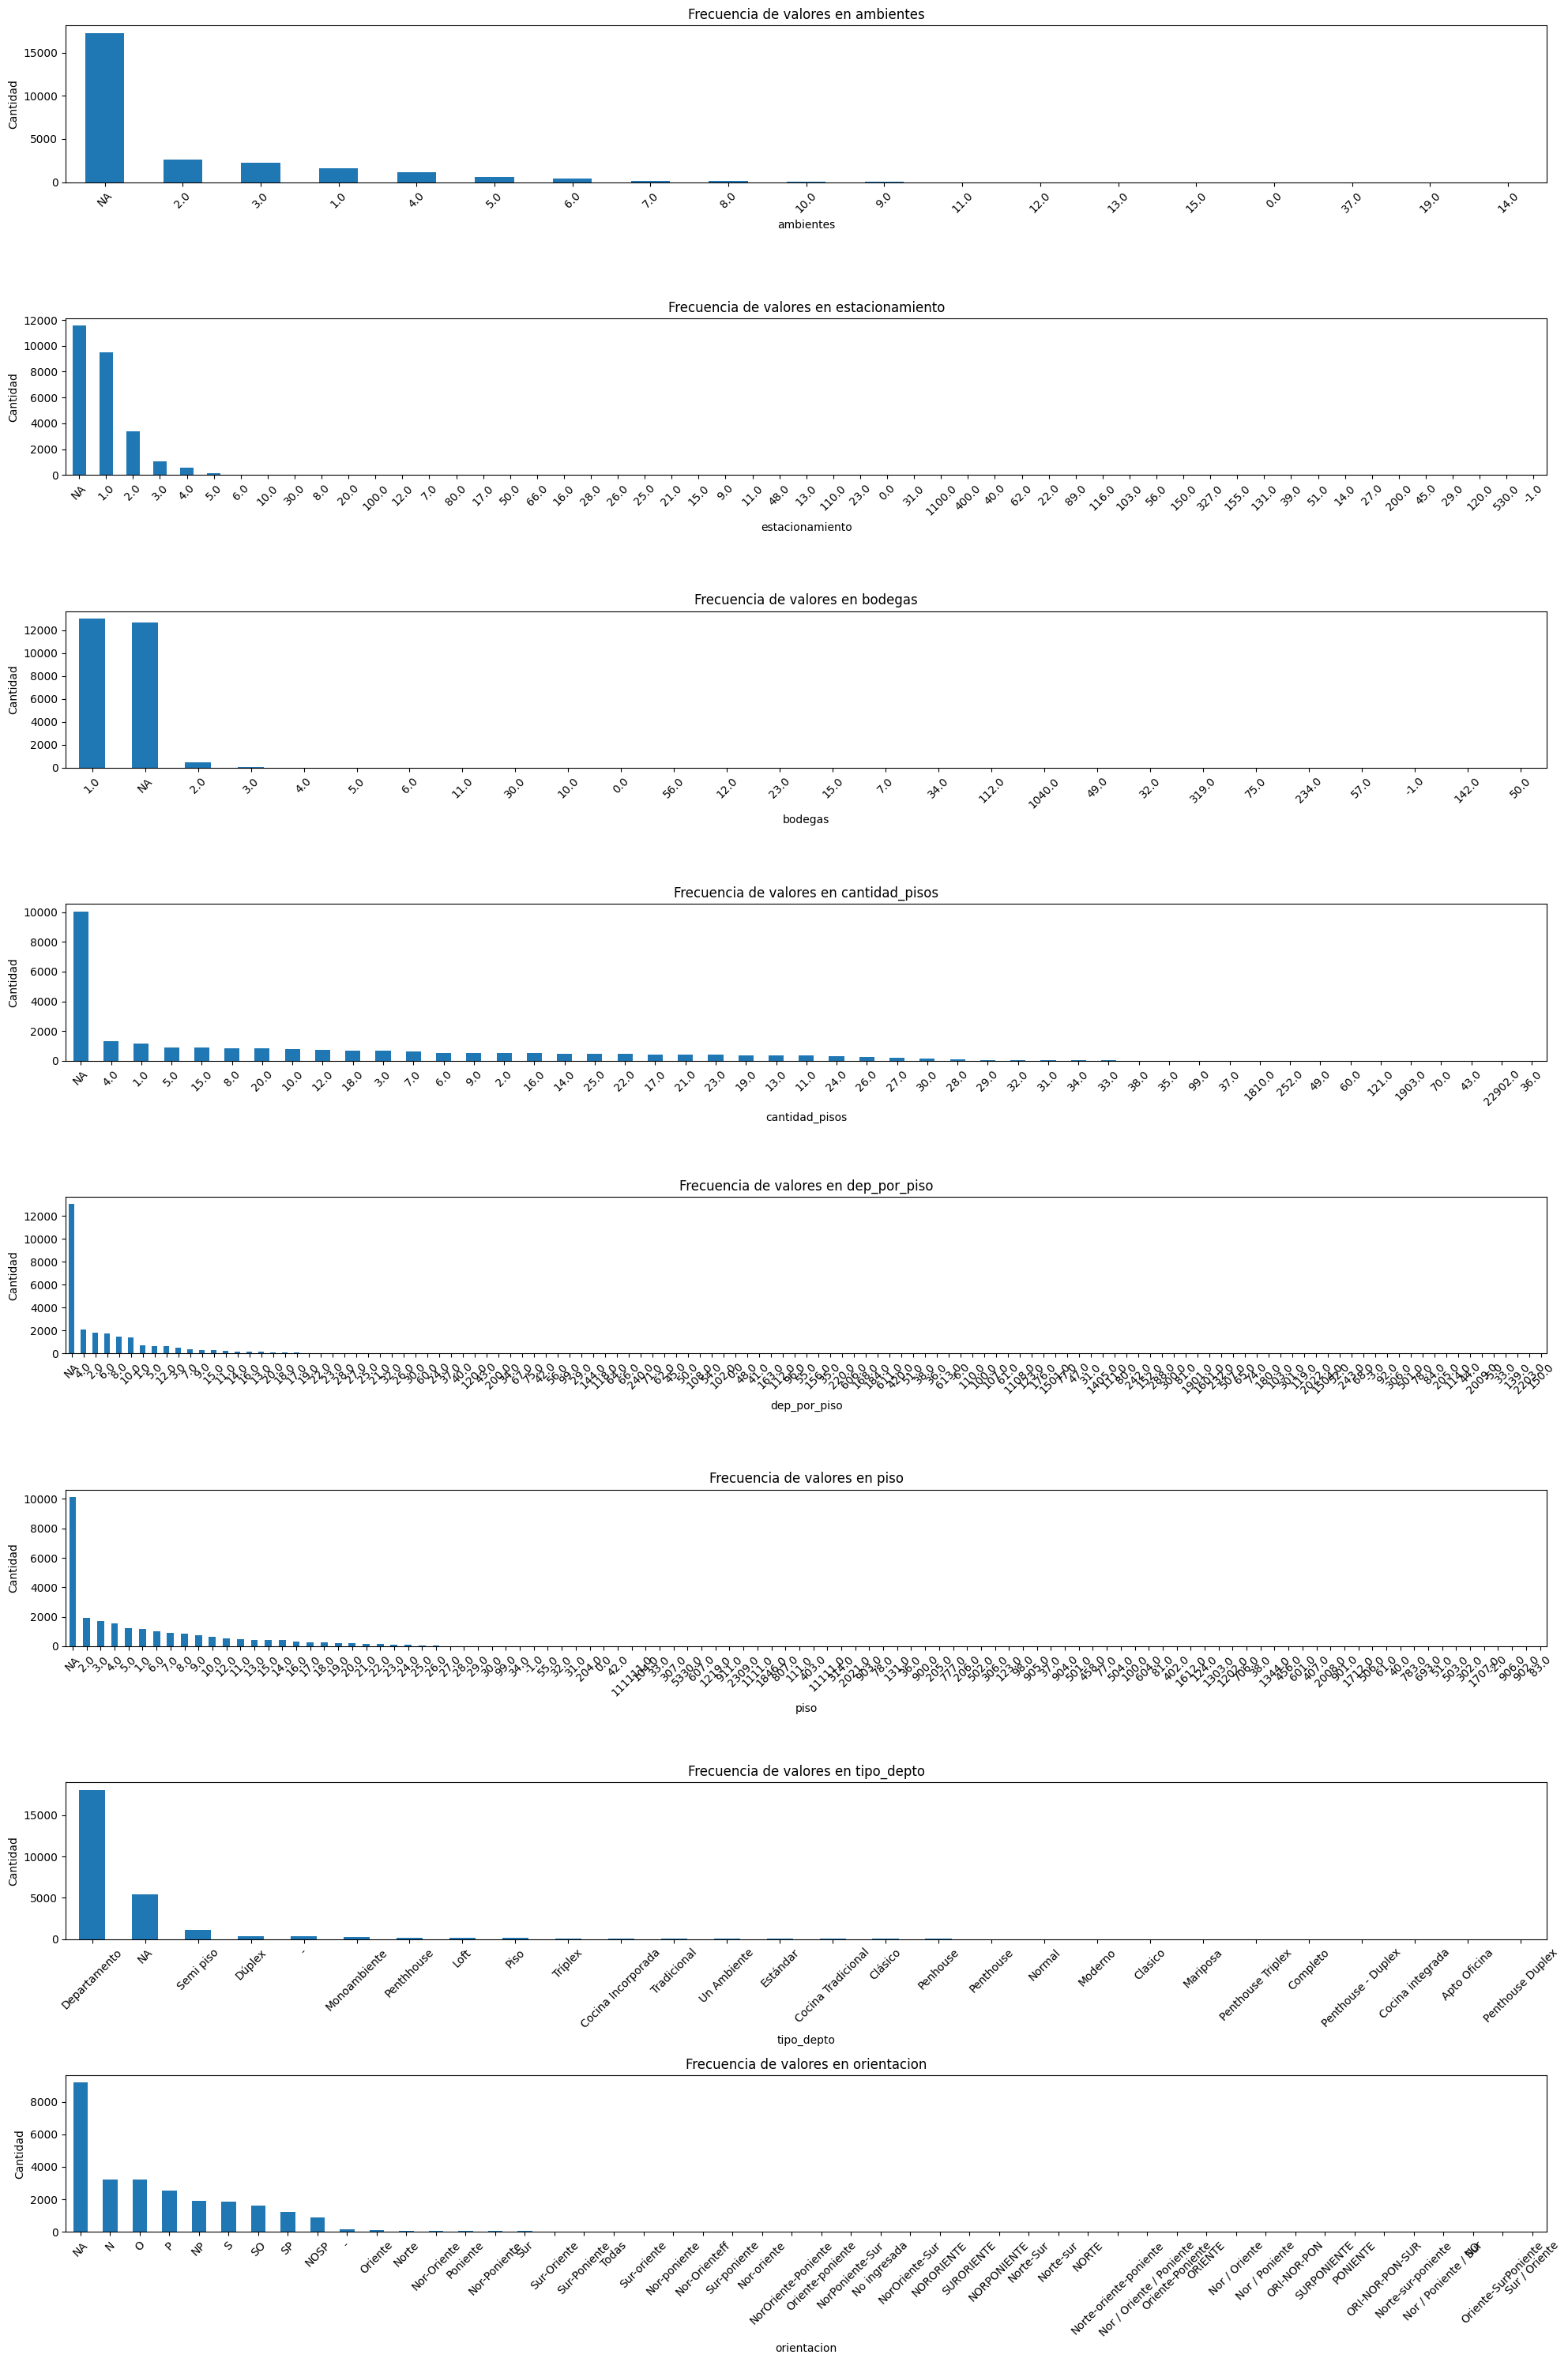

In [24]:
cols = ['ambientes', 'estacionamiento', 'bodegas', 'cantidad_pisos', 
        'dep_por_piso', 'piso', 'tipo_depto', 'orientacion']

plt.figure(figsize=(20, 30))

for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    
    # Convertir todos los valores a string, incluyendo pd.NA correctamente
    series_str = df[col].apply(lambda x: str(x) if pd.notna(x) else 'NA')
    value_counts = series_str.value_counts()
    
    value_counts.plot(kind='bar')
    plt.title(f'Frecuencia de valores en {col}')
    plt.xlabel(col)
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [31]:
df.to_csv('deptos_en_limpieza.csv', index=False)

In [25]:
df.describe()

,id,monto,ppm2,superficie_t,superficie_u,terraza,ambientes,dormitorios,banos,estacionamiento,bodegas,cantidad_pisos,dep_por_piso,piso,antiguedad,latitud,longitud
count,26299.00,26299.00,26294.00,26299.00,26066.00,16981.00,9024.00,25597.00,23986.00,14750.00,13590.00,16239.00,13273.00,16174.00,20586.00,26299.00,26299.00
mean,2246762710.85,7501.28,79.30,134.27,103.05,27.07,2.96,2.33,1.97,1.93,1.22,13.91,9.07,25.03,12.94,-33.44,-70.62
std,627748454.70,9055.07,427.72,1917.82,584.96,273.82,1.76,1.17,1.17,11.73,9.74,180.98,47.77,1240.34,14.09,0.04,0.05
min,1359204515.00,15.00,0.00,1.00,-0.01,0.50,0.00,1.00,1.00,-1.00,-1.00,1.00,-6.00,-2.00,0.00,-33.65,-70.83
25%,1580479350.00,2330.50,53.00,44.00,41.00,3.00,2.00,1.00,1.00,1.00,1.00,5.00,4.00,3.00,3.00,-33.46,-70.65
50%,2751955500.00,3913.00,70.00,65.00,60.00,6.00,3.00,2.00,2.00,1.00,1.00,11.00,6.00,6.00,9.00,-33.44,-70.62
75%,2850891501.00,8600.00,92.00,115.00,100.00,20.00,4.00,3.00,2.00,2.00,1.00,19.00,10.00,11.00,17.00,-33.42,-70.58
max,2864912270.00,158000.00,65000.00,292675.00,66635.00,32543.00,37.00,37.00,43.00,1100.00,1040.00,22902.00,2203.00,111111.00,209.00,-33.28,-70.49


In [27]:
df_dropna = df.dropna().copy()


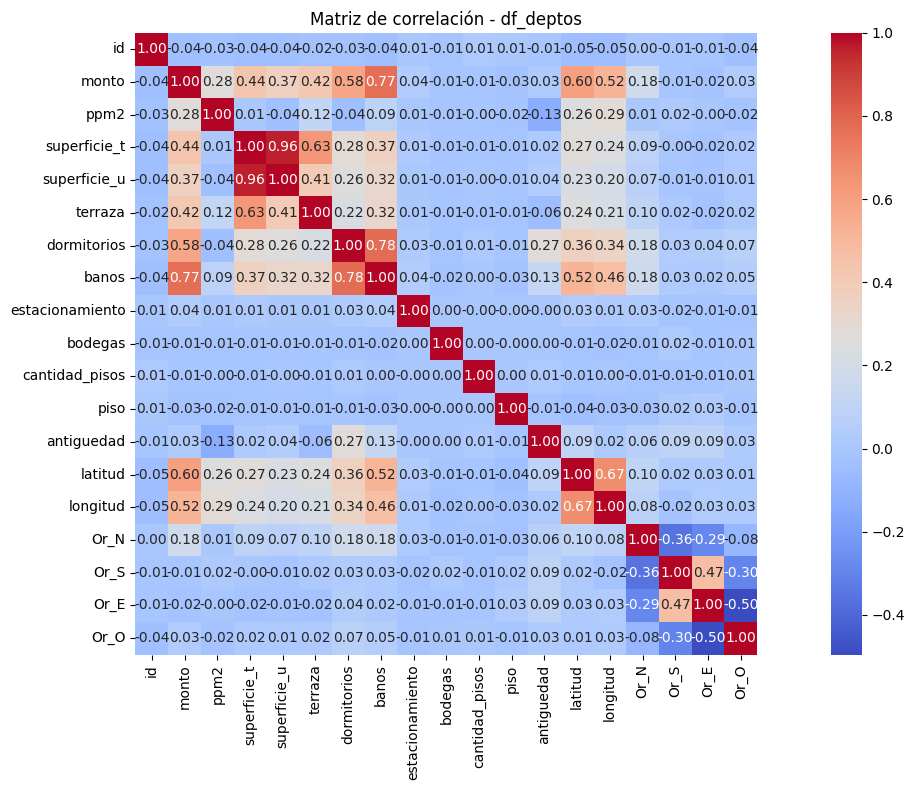

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear matriz de correlación
correlation_matrix = df_dropna.corr(numeric_only=True)

# Graficar la matriz de correlación
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación - df_deptos")
plt.tight_layout()
plt.show()


En las variables numericas parece haber una fuerte relacion lineal entre el monto y banos, dormitorios, terraza, superficie_u y superficie_t, ademas de latitud y longitud. Por otro lado, una muy debil relacion con estacionamiento, bodegas, cantidad_pisos, piso y antiguedad. 
Mas adelante se evalua si en un modelo no lineal estas variables que parecen poco explicativas adquieren mayor valor.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26299 entries, 0 to 26298
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                26299 non-null  int64  
 1   monto             26299 non-null  int64  
 2   ppm2              26294 non-null  float64
 3   superficie_t      26299 non-null  float64
 4   superficie_u      26066 non-null  float64
 5   terraza           16981 non-null  float64
 6   dormitorios       25597 non-null  float64
 7   banos             23986 non-null  float64
 8   estacionamiento   14750 non-null  float64
 9   bodegas           13590 non-null  float64
 10  cantidad_pisos    16239 non-null  float64
 11  piso              16174 non-null  float64
 12  tipo_depto        20883 non-null  object 
 13  antiguedad        20586 non-null  float64
 14  latitud           26299 non-null  float64
 15  longitud          26299 non-null  float64
 16  comuna            26299 non-null  object

MAE: 1164.43
R^2 Score: 0.9232


C:\Users\Pc-ADS\AppData\Local\Temp\ipykernel_28856\761713006.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette='viridis')


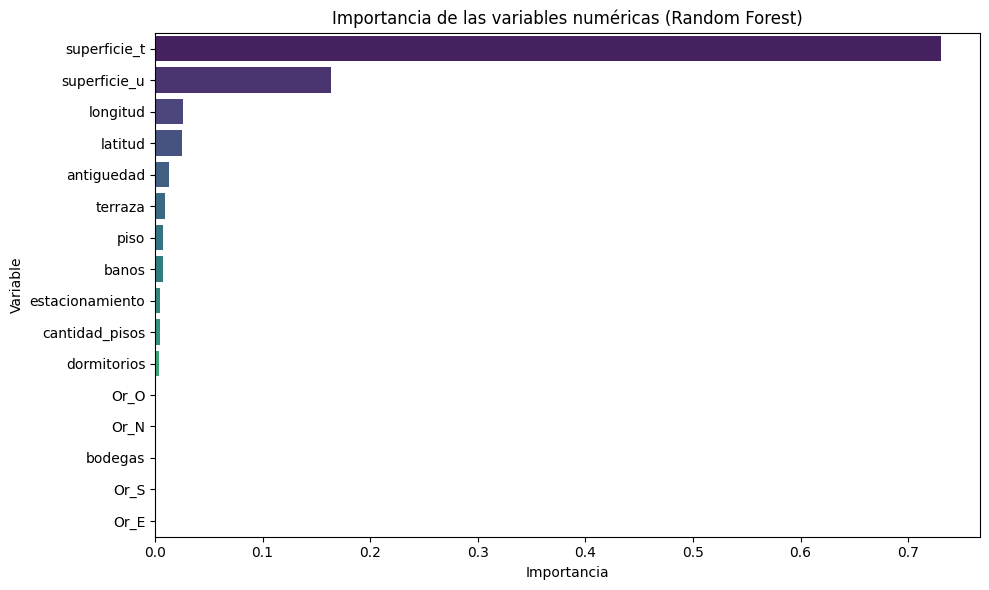

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Variables numéricas seleccionadas
features = [
    'superficie_t', 'superficie_u', 'terraza', 'dormitorios', 'banos',
    'estacionamiento', 'bodegas', 'cantidad_pisos', 'piso',
    'antiguedad', 'latitud', 'longitud', 'Or_N', 'Or_S', 'Or_E', 'Or_O'
]

# 1. Features y target
X = df_dropna[features]
y = df_dropna['monto']

# 2. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Entrenar modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Evaluación
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.4f}")

# 5. Importancia de variables
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Visualización
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.title("Importancia de las variables numéricas (Random Forest)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


Notamos que en un random forest, las variables antiguedad, piso, cantidad_pisos, estacionamiento y bodegas siguen teniendo poco peso. Sin embargo notamos tambien que superficie_t tiene preponderancia casi absoluta comparada con las otras variables.
Mas adelente se realizara otro modelo random forest (para estudiar relaciones no lineales) sin las columnas de superficie.

R²: 0.8589869819279707
MAE: 1728.5510827625571


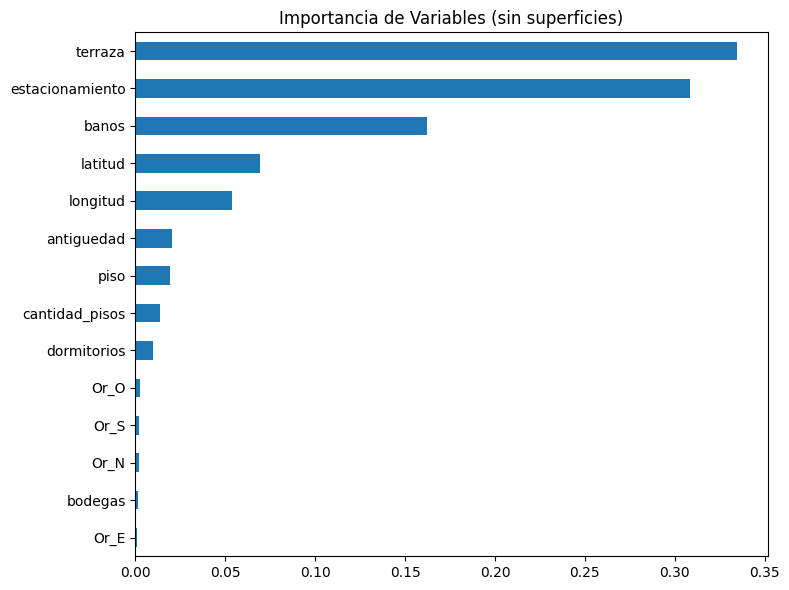

In [30]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Definir variables a usar (excluyendo superficie_t y superficie_u)
features_sin_superficie = [
    'terraza', 'dormitorios', 'banos',
    'estacionamiento', 'bodegas', 'cantidad_pisos', 'piso',
    'antiguedad', 'latitud', 'longitud', 'Or_N', 'Or_S', 'Or_E', 'Or_O'
]

# Asegurarnos de que no haya strings extraños como '-' (por si acaso)
df_model = df_dropna.copy()
for col in features_sin_superficie:
    df_model = df_model[df_model[col].apply(lambda x: isinstance(x, (int, float)))]

# Definir variables predictoras y objetivo
X = df_model[features_sin_superficie]
y = df_model['monto']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Entrenamiento del modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Métricas de evaluación
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Importancia de las variables
importances = pd.Series(model.feature_importances_, index=features_sin_superficie)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 6), title="Importancia de Variables (sin superficies)")
plt.tight_layout()
plt.show()


Al eliminar las superficies, notamos que variables que tenian poca influencia adquieren mas importancia.

##### Analisis de columna orientacion.
 - Imputar datos nulos
 - Normalizar valores
 - Crear columnas Or_N, Or_S, Or_E, Or_O binarias. Mas de una columna puede tener valor 1.
Problema: Muchos datos nulos (9000/26600 aprox). 
Evaluar la posibilidad de predecir los valores de orientacion de acuerdo a otras variables

In [18]:
df['orientacion'] = df['orientacion'].replace(['NA', '-', 'No ingresada'], np.nan)

# Diccionario de reemplazo
reemplazos = {
    'P': 'O', 'Poniente': 'O', 'PONIENTE': 'O',
    'Norte': 'N', 'NORTE': 'N',
    'Sur': 'S', 'SUR': 'S',
    'Oriente': 'E', 'ORIENTE': 'E',
    'SP': 'SO', 'Sur-Poniente': 'SO', 'Sur-poniente': 'SO', 'SURPONIENTE': 'SO',
    'NP': 'NO', 'Nor-Poniente': 'NO', 'NorPoniente': 'NO', 'Nor-poniente': 'NO', 'NORPONIENTE': 'NO',
    'SO': 'SE', 'Sur-Oriente': 'SE', 'Sur / Oriente': 'SE', 'SURORIENTE': 'SE',
    'Nor-Oriente': 'NE', 'Nor / Oriente': 'NE', 'Nor-oriente': 'NE', 'Nor-Orienteff': 'NE', 'NORORIENTE': 'NE',
    'NorOriente-Sur': 'NSE',
    'NorOriente-Poniente': 'NEO',
    'Oriente-SurPoniente': 'SEO',
    'Nor / Oriente / Poniente': 'NEO',
    'Oriente-Poniente': 'EO', 'Oriente-poniente': 'EO',
    'Norte-sur-poniente': 'NSO',
    'Nor / Poniente / Sur': 'NSO',
    'ORI-NOR-PON-SUR': 'NSOE',
    'Todas': 'NSOE',
    'Nor / Poniente': 'NO',
    'Nor / Oriente / Poniente': 'NEO',
    'Norte-Sur': 'NS', 'Norte-sur': 'NS'
}

# Aplicar reemplazos
df['orientacion_norm'] = df['orientacion'].replace(reemplazos)


In [19]:
for letra in 'NSEO':
    df[f'Or_{letra}'] = df['orientacion_norm'].apply(lambda x: int(letra in x) if pd.notna(x) else 0)


In [21]:
df.sample(10)

,id,monto,ppm2,superficie_t,superficie_u,terraza,dormitorios,banos,estacionamiento,bodegas,cantidad_pisos,piso,tipo_depto,orientacion,antiguedad,latitud,longitud,comuna,calle,orientacion_norm,Or_N,Or_S,Or_E,Or_O
3424,2833670022,1409,25.00,55.00,55.00,NaN,3.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,55.00,-33.55,-70.63,La Granja,Las Uvas Y El Viento,NaN,0,0,0,0
12738,2863977846,1780,57.00,32.00,31.00,NaN,1.00,1.00,NaN,NaN,30.00,5.00,Departamento,N,8.00,-33.44,-70.66,Santiago,Rosas,N,1,0,0,0
14931,2767033722,3990,56.00,71.00,71.00,2.00,3.00,2.00,2.00,1.00,17.00,7.00,Departamento,SP,11.00,-33.49,-70.62,Macul,Avenida Escuela Agrícola,SO,0,1,0,1
12670,2854204354,1824,50.00,39.00,36.00,3.00,1.00,1.00,1.00,1.00,31.00,NaN,Departamento,SP,0.00,-33.43,-70.66,Santiago,Avenida Mapocho,SO,0,1,0,1
865,2838249250,37000,92.00,500.00,400.00,100.00,6.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.34,-70.54,Lo Barnechea,Parque Golf,NaN,0,0,0,0
22537,1564032003,5500,84.00,68.00,65.00,3.00,2.00,2.00,1.00,1.00,NaN,13.00,Departamento,SO,NaN,-33.44,-70.60,Providencia,Avenida Suecia,SE,0,1,1,0
6952,2812264926,20000,64.00,310.00,310.00,80.00,4.00,4.00,3.00,1.00,10.00,NaN,Penthhouse,NOSP,NaN,-33.43,-70.56,Las Condes,Avenida Manquehue Sur,NOSP,1,1,0,1
2117,2859126280,2562,49.00,58.00,52.00,6.00,2.00,2.00,NaN,1.00,16.00,9.00,Departamento,NaN,7.00,-33.50,-70.65,San Miguel,Pirámide,NaN,0,0,0,0
18067,1567161019,12800,87.00,167.00,147.00,20.00,3.00,3.00,2.00,1.00,NaN,NaN,Departamento,NaN,5.00,-33.40,-70.58,Vitacura,Luis Carrera,NaN,0,0,0,0
7747,2798948294,16210,119.00,230.00,136.00,NaN,4.00,4.00,1.00,1.00,2.00,1.00,Departamento,SP,1.00,-33.42,-70.51,Las Condes,Avenida Francisco Bulnes Correa,SO,0,1,0,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26299 entries, 0 to 26298
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                26299 non-null  int64  
 1   monto             26299 non-null  int64  
 2   ppm2              26294 non-null  float64
 3   superficie_t      26299 non-null  float64
 4   superficie_u      26066 non-null  float64
 5   terraza           16981 non-null  float64
 6   dormitorios       25597 non-null  float64
 7   banos             23986 non-null  float64
 8   estacionamiento   14750 non-null  float64
 9   bodegas           13590 non-null  float64
 10  cantidad_pisos    16239 non-null  float64
 11  piso              16174 non-null  float64
 12  tipo_depto        20883 non-null  object 
 13  antiguedad        20586 non-null  float64
 14  latitud           26299 non-null  float64
 15  longitud          26299 non-null  float64
 16  comuna            26299 non-null  object